In this notebook we will extract 10-k financial statement for the companies of our interest from the Security and Exchange Commision (SEC), clean data, pre-process and make basic sentiment analysis

# ANALYSING 10-K FINANCIAL STATEMENTS

### Importing necessary packages

In [1]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import project_helper
import project_tests                   #!!!!!!!!! REMOVE LATERS if not needed !!!!!!!!!!!!!!!!!!!

from tqdm import tqdm

Here we will download a nltk corpora to be used later in this project

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

### Choosing companies to analyse their 10k's and downloading the 10k's

Now we enter the companies of our interest: 
###### Amazon, Apple, Microsoft, Tesla, Nike, Facebook, Google

In [3]:
# creating dict of indecies of our interest
cik_lookup = {
    'AMZN': '0001018724',    
    'APL': '0000320193',
    'MSFT': '0000789019',
    'TSL': '0001318605',
    'NKE': '0000320187',
    'FB': '0001326801',
    'GOOGL': '0001288776',
    }

Here we will use `SecAPI` class provided to us by UDACITY (can be found inside `project_helper`) in order to avoid SEC's limit of calls per second. 

###### Note to self: (NOT 100% sure how this works)

In [4]:
sec_api = project_helper.SecAPI()

Downloading list of filled 10-k's.

###### Note to self: Here we choose a parameter of date for the first time! we should parametrize this later

In [5]:
#importing BS
from bs4 import BeautifulSoup


def get_sec_data(cik, doc_type, start=0, count=60):
    """
    Extract 10k's into a list
    
    Parameters:
    -----------
    cik : dict
            List of ciks
    doc_type : string 
            Type of documents that interests us
    start : int
            setting for the website
    count : int
            ammount of pages to load I guess 60
            
    Returns:
    --------
    entries : list 
                A list of url's for doc_type for a date for the cik company in the SEC Database that we acess
    """
    
    #setting date for the newest pricing data PARAMETRIZE DATE LATER!!!!!!
    newest_pricing_data = pd.to_datetime('2018-01-01')
    
    #entering URL to directly acces 10k's, WE NEED TO UNDERSTAND THE STRUCTURE OF THE URL ADRESS FOR THIS ONE!
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    
    #entering url into the helper class sec_api 
    sec_data = sec_api.get(rss_url)
    
    # USING BEAUTIFUL SOUP to extract the HTML version of the webiste
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    #print(feed)
    
    #this must create a list of entries of 10k's from the SEC Database
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)
        if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_pricing_data]

    return entries

In [7]:
# testing
example_ticker = 'APL'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

pprint.pprint(sec_data[example_ticker][:5])

[('https://www.sec.gov/Archives/edgar/data/320193/000032019317000070/0000320193-17-000070-index.htm',
  '10-K',
  '2017-11-03'),
 ('https://www.sec.gov/Archives/edgar/data/320193/000162828016020309/0001628280-16-020309-index.htm',
  '10-K',
  '2016-10-26'),
 ('https://www.sec.gov/Archives/edgar/data/320193/000119312515356351/0001193125-15-356351-index.htm',
  '10-K',
  '2015-10-28'),
 ('https://www.sec.gov/Archives/edgar/data/320193/000119312514383437/0001193125-14-383437-index.htm',
  '10-K',
  '2014-10-27'),
 ('https://www.sec.gov/Archives/edgar/data/320193/000119312513416534/0001193125-13-416534-index.htm',
  '10-K',
  '2013-10-30')]


In [8]:
# entering the url and avoiding metadata (by replacing url adress) and accessing .txt file 
# saving the whole content into the dict with ticker and date as a key and document as a string
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0000320193-17-000070.txt : 20171103
<SEC-HEADER>0000320193-17-000070.hdr.sgml : 20171103
<ACCEPTANCE-DATETIME>20171103080137
ACCESSION NUMBER:		0000320193-17-000070
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		97
CONFORMED PERIOD OF REPORT:	20170930
FILED AS OF DATE:		20171103
DATE AS OF CHANGE:		20171103

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			APPLE INC
		CENTRAL INDEX KEY:			0000320193
		STANDARD INDUSTRIAL CLASSIFICATION:	ELECTRONIC COMPUTERS [3571]
		IRS NUMBER:				942404110
		STATE OF INCORPORATION:			CA
		FISCAL YEAR END:			0930

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	001-36743
		FILM NUMBER:		171174673

	BUSINESS ADDRESS:	
		STREET 1:		ONE INFINITE LOOP
		CITY:			CUPERTINO
		STATE:			CA
		ZIP:			95014
		BUSINESS PHONE:		(408) 996-1010

	MAIL ADDRESS:	
		STREET 1:		ONE INFINITE LOOP
		CITY:			CUPERTINO
		STATE:			CA
		ZIP:			95014

	FORMER COMPANY:	
		FORMER CONFORMED NAME:	APPLE COMPUTER

Now because every 10k filing has different information containing, we want to narrow it down to the documents iteslf

In [9]:
import re

def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
        # setting the regexes for the beginning and end of the document 
    begin_regex = re.compile(r'<DOCUMENT>')
    end_regex = re.compile(r'</DOCUMENT>')
    
    # extracting the numerical value of a beginning and an end of a string
    begin_positions = [x.end() for x in begin_regex.finditer(text)]
    end_positions = [x.start() for x in end_regex.finditer(text)]

    extracted_docs = []
    if len(begin_positions) == len(end_positions):
        for begin, end in zip(begin_positions, end_positions):
            extracted_docs.append(text[begin:end])
    
    return extracted_docs



In [10]:
# creating dict with keys: Ticker:Date:Documnet itself
filling_documents_by_ticker = {}

#extracting
for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from GOOGL Fillings: 100%|██████████| 12/12 [00:00<00:00, 45.47filling/s]

Document 0 Filed on 2017-11-03:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>a10-k20179302017.htm
<DESCRIPTION>10-K
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
	<head>
		...

Document 1 Filed on 2017-11-03:

<TYPE>EX-10.8
<SEQUENCE>2
<FILENAME>a10-kexhibit1082017.htm
<DESCRIPTION>EXHIBIT 10.8
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<ht...

Document 2 Filed on 2017-11-03:

<TYPE>EX-10.20
<SEQUENCE>3
<FILENAME>a10-kexhibit10202017.htm
<DESCRIPTION>EXHIBIT 10.20
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
...


Because the structure of the 10k- filings it has different types of documents inside. We will only want to extract 10-k form

In [11]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    
    #filter and extract names of the each form
    regex_type = re.compile(r'<TYPE>(\S)*')
    #find_types_position = regex_type.finditer(doc)
    begin_position = [x.start() for x in regex_type.finditer(doc)]
    end_position = [x.end() for x in regex_type.finditer(doc)]
    #print(begin_position, end_position)
    doc_type =  doc[(begin_position[0]+6):end_position[0]].lower()
    return doc_type

In [12]:
# creating a dict with {Ticker: [{cik: ----, file: ----, file_date: ---}]} structure
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0000320193'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>a10-k2017930...
    file_date: '2017-11-03'},
  {
    cik: '0000320193'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>a201610-k924...
    file_date: '2016-10-26'},
  {
    cik: '0000320193'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>d17062d10k.h...
    file_date: '2015-10-28'},
  {
    cik: '0000320193'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>d783162d10k....
    file_date: '2014-10-27'},
  {
    cik: '0000320193'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>d590790d10k....
    file_date: '2013-10-30'},
]


### Preprocessing Data and Cleaning Data; Lemmatizing and Removing Stopwords

In [13]:
# function to remove html
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text

# function to lower text and remoce html tags
def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

In [14]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning GOOGL 10-Ks: 100%|██████████| 12/12 [00:33<00:00,  2.82s/10-K]

[
  {
    file_clean: '\n10-k\n1\na10-k20179302017.htm\n10-k\n\n\n\n\n\n...},
  {
    file_clean: '\n10-k\n1\na201610-k9242016.htm\n10-k\n\n\n\n\n\n...},
  {
    file_clean: '\n10-k\n1\nd17062d10k.htm\nform 10-k\n\n\nform 10...},
  {
    file_clean: '\n10-k\n1\nd783162d10k.htm\n10-k\n\n\n10-k\n\n\nt...},
  {
    file_clean: '\n10-k\n1\nd590790d10k.htm\nform 10-k\n\n\nform 1...},
]


In [15]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    lem = WordNetLemmatizer()
    lemmatized_words = []
    for word in words:
        #print('\noriginal word:'+ word)
        lemmatized_word = lem.lemmatize(word, pos='v')
        #print('\nlemmatized word:'+ wn._morphy(lemmatized_word, wn.NOUN))
        lemmatized_words.append(lemmatized_word)
    return lemmatized_words

In [16]:
#using this regex to find all words inside the 10k dict for each element in "cleaned version"
#might consider as adding a dimension to 10k dict with list of lemmatized words
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize GOOGL 10-Ks: 100%|██████████| 12/12 [00:04<00:00,  2.8710-K/s]

[
  {
    file_lemma: '['10', 'k', '1', 'a10', 'k20179302017', 'htm', '1...},
  {
    file_lemma: '['10', 'k', '1', 'a201610', 'k9242016', 'htm', '1...},
  {
    file_lemma: '['10', 'k', '1', 'd17062d10k', 'htm', 'form', '10...},
  {
    file_lemma: '['10', 'k', '1', 'd783162d10k', 'htm', '10', 'k',...},
  {
    file_lemma: '['10', 'k', '1', 'd590790d10k', 'htm', 'form', '1...},
]


In [17]:
from nltk.corpus import stopwords

#removing stopwords for each 
lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('Stop Words Removed')

Remove Stop Words for GOOGL 10-Ks: 100%|██████████| 12/12 [00:01<00:00,  9.3010-K/s]

Stop Words Removed


Now we lemmatized words, removed the stop words, and it seems to be ready for analysis. 

###### Note to self: Yet we still have lots of irrelevant info inside the 'file_lemma' list

### Analysis on 10K

#### Lougharn McDonald Sentiment Word list

In [29]:
# we get a LMSW csv file from the udacity repositary https://github.com/hkailee/Udacity/find/master
# here we reprocess this file to be used in our applicaton
import os

#choosing list of sentiments that we are interested in 
#original consists of: negative, positive, uncertainty, litigious, constaringing, superfluous, interesting, model, irr_verb, harvard_iv, syllables
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

#reading csv file from the data folder
sentiment_df = pd.read_csv(os.path.join('data/10k_loughran_mcdonald/loughran_mcdonald_master_dic_2016.csv'))
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']] # omitting irrelevant data such as std dev word count and etc
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool) # creating true or false expression
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)] #checks if a single line is true (aka removes unused words)


# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())

sentiment_df = sentiment_df.drop_duplicates('word')


sentiment_df.head(20)

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication
55,True,False,False,False,False,False,abdications
70,True,False,False,False,False,False,aberrant
71,True,False,False,False,False,False,aberration
72,True,False,False,False,False,False,aberrational
73,True,False,False,False,False,False,aberrations


#### Bag of Words
Creating for each sentiment in the document a vectorization of words

In [42]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # creating a vecrotization of the sentiment words from the df we created
    count_vector = CountVectorizer(vocabulary=sentiment_words)
    # fitting the document to the vector of sentiment words
    bag_of_words = count_vector.fit_transform(docs).toarray()
    
    return bag_of_words
    
    
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

project_tests.test_get_bag_of_words(get_bag_of_words)

Tests Passed


In [43]:
# here we will create for each ticker a list of sentiments per documents in the form of
# {ticker1: [{sentiment1: '[vector_for_ticker1_document1],[vector_for_ticker_1_document2]'; sentiment2:[...]}];ticker2: ...}
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    # Create a extracting list of lemmatized words for each 10k, this must be in a date-descending order
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    #because we did boolen type, the following will return words for specified sentiment from sent_df, and see which ones are in lemma docs.
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}


project_helper.print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    positive: '[[9 0 0 ... 0 0 0]\n [9 0 0 ... 0 0 0]\n [9 0 0 ....
    uncertainty: '[[0 0 0 ... 2 0 8]\n [0 0 0 ... 2 0 8]\n [0 0 0 ....
    litigious: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    constraining: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    interesting: '[[5 1 0 ... 0 0 0]\n [4 2 0 ... 0 0 0]\n [4 2 0 ....},
]


#### Jaccard Similarity

Jaccard similarty to see how the 10k document sentiments in the bow change within time 

###### Note to self: (not entirely sure how this helps us with the analysis) and why my graph happened to be reverse from the one in the exercise

In [45]:
from sklearn.metrics import jaccard_similarity_score


def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    #reducing information to 1 = word present, 0 = word absent
    bag_of_words = bag_of_words_matrix.astype(bool)
    #
    jaccard_similarities = [jaccard_similarity_score(u,v) for u, v in zip(bag_of_words,bag_of_words[1:])]
    return jaccard_similarities
    

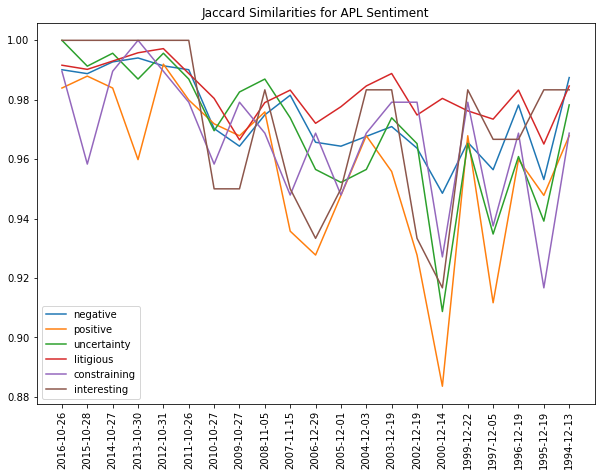

In [46]:
# Here we create Jaccard similarities for the sentiments of interest, aka, we see, how two vectors of bog are similar  
# in neigbouring documents 
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}


project_helper.plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

#### TFIDF

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    #creating a vecortiezer to create TFIDF Score for each word in the document
    vectorizer = TfidfVectorizer(vocabulary = sentiment_words)
    tfidf = vectorizer.fit_transform(docs).toarray()
    
    return tfidf


In [51]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

    
project_helper.print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    positive: '[[0.11586874 0.         0.         ... 0.        ...
    uncertainty: '[[0.         0.         0.         ... 0.00811961...
    litigious: '[[0.         0.         0.         ... 0.        ...
    constraining: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    interesting: '[[0.06665465 0.01659864 0.         ... 0.        ...},
]


#### Cosine Similarity
Almost same information as Jaccardian similarity, but now we take into the account the relevance of each word in the whole document sphere. Hence we see more how the documents changed within times in terms of relevant information to today

In [53]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    # TODO: Implement
    cos_similarity= cosine_similarity(tfidf_matrix[0:], tfidf_matrix[1:])
    
    return cos_similarity[0].tolist()



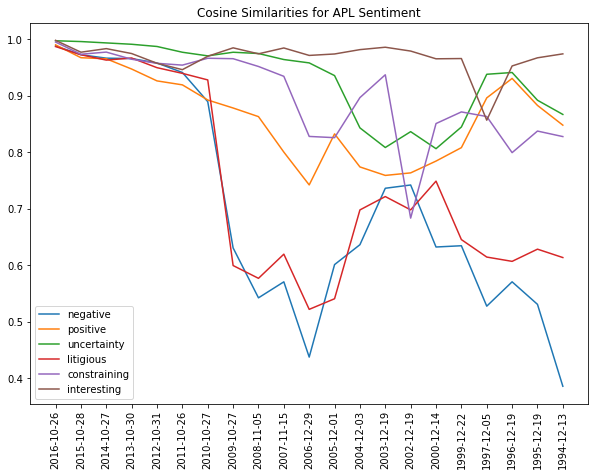

In [54]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


project_helper.plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

### Evaluating Alpha Factors

We will do this ANALYSIS A BIT LATER! COME BACK TO THIS ONE LATER